In [1]:
'''
:author: Jacek Mucha
Start:  19.12.2018
Uwagi: 
1. Zrefaktoryzować kod. Obecnie klasa Board jest traktowana jako statyczna. Bardziej elegancko byłoby
utworzyć na początku jej instancję i przekazywać do innych obiektów tę instancję jako parametr.
2. Utworzyć PreyFactory
'''

'\n:author: Jacek Mucha\nStart:  19.12.2018\nUwagi: \n1. Zrefaktoryzować kod. Obecnie klasa Board jest traktowana jako statyczna. Bardziej elegancko byłoby\nutworzyć na początku jej instancję i przekazywać do innych obiektów tę instancję jako parametr.\n2. Utworzyć PreyFactory\n'

In [ ]:
import numpy as np
import math as mt
import random as rn
import cmath as cmt
import matplotlib.pyplot as plt
import matplotlib.colors as cl
from mpl_toolkits.mplot3d import Axes3D
import imageio


In [3]:
import copy
import pandas as pd
import os
import multiprocessing as mp

In [4]:
class Boids:
    species = ["Aegithalos","Sturnus", "Columba", "Panurus",  "Carduelis"]
    
    def gen_colour(species):
        if species == "Sturnus": #kolor hebanowy
            r = 61
            g = 43
            b = 31
        elif species == "Columba": #kolor gołębi
            r = 198
            g = 206
            b = 206
        elif species == "Aegithalos": #cynober
            r = 227
            g = 66
            b = 52
        elif species == "Panurus": #morelowy
            r = 233
            g = 150
            b = 123
        elif species == "Carduelis": #żółty
            r = 225
            g = 225
            b = 30
        elif species == "Accipiter": #pistacjowy
            r = 159
            g = 225
            b = 136
        return (r+rn.randint(-30,30),g+rn.randint(-30,30),b+rn.randint(-30,30))

In [5]:
class ExtendedBoids(Boids):
    
    def __init__(self, board_size = (200,200,200), searching_for_food = False, number_of_boids = [20], 
                number_of_predators = 0, min_distance = [15], flat_angle = [120], neighbourhood_distance = [60],
                maximum_speed = [5], separation_weight = [0.15], cohension_weight = [0.18], alignment_weight = [0.12],
                noise = [0.1], obstacles = [], z_angle = [120]):
        self._number_of_boids = number_of_boids
        self._board_size = board_size
        self._searching_for_food = searching_for_food
        self._number_of_boids = number_of_boids
        self._number_of_predators = number_of_predators
        self._min_distance = min_distance
        self._flat_angle = flat_angle
        self._neighbourhood_distance = neighbourhood_distance
        self._maximum_speed = maximum_speed
        self._separation_weight = separation_weight
        self._cohension_weight = cohension_weight
        self._alignment_weight = alignment_weight
        self._noise = noise
        self._obstacles = obstacles
        self._number_of_prey_species = len(number_of_boids)
        self._z_angle = z_angle
        self._identifier = 0
        self._step = 0
        
        self._board = Board()
        
        self.check_input_data()
        
        self.clear_board()
        self.create_board()
        self.add_obstacles()
        self.populate_board()
#wyjątki długości list    

    def add_obstacles(self):
        for obs in self._obstacles:
            self.add_obstacle(obs)

    def add_obstacle(self,obs):
        Board.obstacles.append(Obstacle(obs[0],obs[1],obs[2],obs[3]))
        
    def create_species(self,species_id):
        return Species(Boids.species[species_id], self._min_distance[species_id], self._flat_angle[species_id],
                    self._neighbourhood_distance[species_id], self._maximum_speed[species_id], 
                    self._separation_weight[species_id], self._cohension_weight[species_id], 
                    self._alignment_weight[species_id],self._z_angle[species_id],self._noise[species_id])
        
    def check_obstacles(self,x,y,z):
        for obs in self._obstacles:
            if mt.sqrt( (x-obs[0])**2.0 + (y-obs[1])**2.0 + (z-obs[2])**2.0) <= obs[3]:
                return False
        return True
        
    def create_prey(self,species):
        x = rn.uniform(0.0,Board.xlim)
        y = rn.uniform(0.0,Board.ylim)
        z = rn.uniform(0.0,Board.zlim)
        
        while not self.check_obstacles(x,y,z):
            x = rn.uniform(0.0,Board.xlim)
            y = rn.uniform(0.0,Board.ylim)
            z = rn.uniform(0.0,Board.zlim)
        
        maxv = Board.species[species].get_maxv()
        
        vx = rn.uniform(-maxv,maxv)
        vy = rn.uniform(-maxv,maxv)
        vz = rn.uniform(-maxv,maxv)
        
        colour = Boids.gen_colour(species)
        ident = self._identifier
        self._identifier += 1
        
        return Prey(x,y,z,vx,vy,vz,ident,species,colour)
        
    def create_board(self):
        Board.xlim = self._board_size[0]
        Board.ylim = self._board_size[1]
        Board.zlim = self._board_size[2]
        
    def populate_board(self):
        for s in range(self._number_of_prey_species):
            Board.species[Boids.species[s]] = self.create_species(s)
            for boid_id in range(self._number_of_boids[s]):
                b = self.create_prey(Boids.species[s])
                Board.prey.append(b)
                
    def copy_situation(self):
        Board.new_prey = []
        Board.new_predators = []
        for p in Board.prey:
            Board.new_prey.append(p)
        for p in Board.predators:
            Board.new_predators.append(p)
            
    def board_step(self):
        self.copy_situation()
        for p in Board.predators:
            p.hunt()
        #kill_prey()
        #output = mp.Queue()
        #list_of_objects = [Board.prey[i] for i in range(len(Board.prey))]
        #processes = [mp.Process(target=self.par_step, args=(i)) for i in range(len(Board.prey))]
        #pool = mp.Pool(4)
        #pool.map(self.worker, (obj for obj in list_of_objects))
        #pool.close()
        #pool.join()
        for p in Board.prey:
            p.step()
        #for p in processes:
        #    p.start()
        #for p in processes:
        #    p.join()
        self._step+=1
        Board.steps = self._step
    
    def par_step(self,p):
        Board.prey[i].step()
        
    def worker(self,obj):
        return obj.step()
    
    def clear_board(self):
        Board.prey = []
        Board.new_prey = []
        Board.predators = []
        Board.new_predators = []
        Board.obstacles = []
        Board.species = {}
        
    def check_input_data(self):
        '''
        Funkcja sprawdzająca poprawność wprowadzonych danych. Jeżeli lista zadeklarowanych liczebności gatunków 
        ma większą długość n niż inne listy odpowiadające parametrom tych gatunków, to listy te są modyfikowane w sposób 
        lista[0]*n
        '''
        n = len(self._number_of_boids)
        if n > 5:
            n=5
        if len(self._min_distance) < n:
            self._min_distance = [self._min_distance[0]]*n
        if len(self._flat_angle) < n:
            self._flat_angle = [self._flat_angle[0]]*n
        if len(self._neighbourhood_distance) < n:
            self._neighbourhood_distance = [self._neighbourhood_distance[0]]*n
        if len(self._maximum_speed) < n:
            self._maximum_speed = [self._maximum_speed[0]]*n
        if len(self._separation_weight) < n:
            self._separation_weight = [self._separation_weight[0]]*n
        if len(self._cohension_weight) < n:
            self._cohension_weight = [self._cohension_weight[0]]*n
        if len(self._alignment_weight) < n:
            self._alignment_weight = [self._alignment_weight[0]]*n
        if len(self._noise) < n:
            self._noise = [self._noise[0]]*n
        if len(self._z_angle) < n:
            self._z_angle = [self._z_angle[0]]*n
        

            
            
        

In [6]:
class Species:
    def __init__(self,name ="Sturnus", min_distance = 15, view_angle = 120, neighbourhood_distance = 50,
                maximum_speed = 6, separation_weight = 0.15, cohension_weight = 0.15, alignment_weight = 0.10, 
                z_angle = 120, noise = 1.0):
        self._min_distance = min_distance
        self._view_angle = view_angle
        self._neighbourhood_distance = neighbourhood_distance
        self._maximum_speed = maximum_speed
        self._separation_weight = separation_weight
        self._cohension_weight = cohension_weight
        self._alignment_weight = alignment_weight
        self._name = name
        self._z_angle = z_angle
        self._noise = noise
        
    def get_maxv(self):
        return self._maximum_speed
    
    def getParameters(self):
        return self._min_distance, self._view_angle, self._neighbourhood_distance, self._maximum_speed, 
        self._separation_weight, self._cohension_weight, self._alignment_weight, self._name = name, self._z_angle
        
    def getNeighbourDistance(self):
        return self._neighbourhood_distance
    
    def getViewAngle(self):
        return self._view_angle
    
    def getZAngle(self):
        return self._z_angle
    
    def get_alignment(self):
        return self._alignment_weight
    
    def get_cohension(self):
        return self._cohension_weight
    
    def get_separation(self):
        return self._separation_weight
    
    def get_mind(self):
        return self._min_distance

    def get_noise(self):
        return self._min_distance
                

In [7]:
class Board:
    ''' Pomocnicza klasa ze zmiennymi statycznymi.
    '''
    xlim = 200
    ylim = 200
    zlim = 0
    prey = []
    new_prey = []
    predators = []
    new_predators = []
    obstacles = []
    species = {}
    steps = 0

In [8]:
class Boid:
    
    def __init__(self,x,y,z,vx,vy,vz,identifier,colour):
        self._x = x
        self._y = y
        self._z = z
        self._vx = vx
        self._vy = vy
        self._identifier = identifier
        self._colour = colour
        
    def getX(self):
        return self._x
    
    def getY(self):
        return self._y
    
    def getZ(self):
        return self._z
    
    def getVx(self):
        return self._vx
    
    def getVy(self):
        return self._vy
    
    def getVz(self):
        return self._vz
    
    def getCoordinates(self):
        return self._x, self._y, self._z
    
    def getVelocities(self):
        return self._vx, self._vy, self._vz
    
    def setColour(self,r,g,b):
        self._colour = [r,g,b]
    
    def setCoordinates(self,x,y,z):
        self._x = x
        self._y = y
        self._z = z
    
    def setVelocities(self,vx,vy,vz):
        self._vx = vx
        self._vy = vy
        self._vz = vz
        
    def periodic(self,x,m):
        if x>=0.5*m:
            return x-m
        elif x<-0.5*m:
            return x+m
        else:
            return x
        
    def distanceX(self, x, y, m):
        return min(abs(self.periodic(x,m)-self.periodic(y,m)), abs(x-y))
    
    def getColour(self):
        return self._colour

    def distance(self,boid):
        nx, ny, nz = boid.getX(), boid.getY(), boid.getZ()
        return mt.sqrt( self.distanceX(self._x,nx,Board.xlim)**2.0 + \
                      self.distanceX(self._y,ny,Board.ylim)**2.0 + \
                      self.distanceX(self._z,nz,Board.zlim)**2.0)

    def to_radians(self, angle):
        return angle/360.0*2.0*mt.pi
    
    def angle(self,boid):
        v = mt.sqrt(self._vx**2.0 + self._vy**2.0 + self._vz**2.0)
        x = ( boid.getX() - self._x)
        y =  (boid.getY() - self._y)
        z = (boid.getZ() - self._z)
        u = mt.sqrt(x**2.0 + y**2.0 + z**2.0)
        if u == 0 or v == 0:
            return mt.pi / 2
        prod = x * self._vx + y * self._vy + z * self._vz 
        dist = self.distance(boid)
        mdist = Board.xlim/2.0 #należałoby policzyć inaczej, ale zależy nam na szybkości obliczeń
        return (mt.acos(prod/(u*v))+(dist>mdist)*mt.pi/2.0) %  mt.pi
    

In [9]:
class Prey(Boid):
    def __init__(self, x, y, z, vx, vy, vz, identifier, species, colour):
        self._x = x
        self._y = y
        self._z = z
        self._vx = vx
        self._vy = vy
        self._vz = vz
        self._identifier = identifier
        self._species = species
        self._colour = colour
        self._neighbours = []
        self._prey = []
        self._predators = []
        self._obstacles = []
        
    def getSpecies(self):
        return self._species
    
    def getId(self):
        return self._identifier
    
    def get_species_parameters(self):
        return Board.species[self.getSpecies()].getParameters()
    
    def neighbour_distance(self):
        return Board.species[self.getSpecies()].getNeighbourDistance()
    
    def limflat_angle(self):
        return self.to_radians(Board.species[self.getSpecies()].getViewAngle())
    
    def limz_angle(self):
        return self.to_radians(Board.species[self.getSpecies()].getZAngle())
    
    def alignment_weight(self):
        return Board.species[self.getSpecies()].get_alignment()
    
    def cohension_weight(self):
        return Board.species[self.getSpecies()].get_cohension()
    
    def separation_weight(self):
        return Board.species[self.getSpecies()].get_separation()
    
    def mind(self):
        return Board.species[self.getSpecies()].get_mind()
    
    def get_noise(self):
        return Board.species[self.getSpecies()].get_noise()

    def get_maxv(self):
        return Board.species[self.getSpecies()].get_maxv()
        
    def find_neighbours(self, mine = True):
        ''' Funkcja przeszukująca statyczną listę new_prey z klasy Board i zwracająca listę sąsiadów, 
        tzn. takich obiektów klasy Prey, które
        1. są tego samego gatunku (species), co self
        2. znajdują się bliżej niż neighbour_distance() od self (wartość liczbowa wspólna dla danej instancji Species)
        3. znajdują się kącie widzenia

        '''
        n = []
        if len(Board.new_prey) == 0:
            print("alert")
        if mine:
            for b in Board.new_prey:
                if self.check_species(b) and self._identifier != b.getId():
                    if self.distance(b) <= self.neighbour_distance() and \
                    self.angle(b) <= self.limflat_angle()*0.5:
                        n.append(b)  
        else:
            for b in Board.new_prey:
                if self._identifier != b.getId():
                    if self.distance(b) <= self.neighbour_distance() and \
                    self.angle(b) <= self.limflat_angle()*0.5:
                        n.append(b)              
        return n
                
    def mean_velocities(self):
        VX = []
        VY = []
        VZ = []
        for b in self._neighbours:
            VX.append(b.getVx())
            VY.append(b.getVy())
            VZ.append(b.getVz())
        #print(VX)
        return np.mean(VX), np.mean(VY), np.mean(VZ)
    
    def mean_distance(self):
        distances = []
        for b in self._neighbours:
            distances.append(self.distance(b))
        return np.mean(distances)
                 
    def find_predators(self):
        p = []
        for b in Board.new_predators:
            if self.distance(b) <= self.neighbour_distance() and \
            self.angle(b) <= self.limflat_angle()*0.5:
                p.append(b) 
        return p
    
    def find_obstacles(self):
        pass
    
    def separation(self, vx, vy, vz):
        Vx, Vy, Vz = vx, vy, vz
        weight = self.separation_weight()
        proximity = self.mind()
        for b in self._prey:
            d = self.distance(b)
            Vx = Vx - weight*( (b.getX()- self.getX())*proximity/d - (b.getX()- self.getX()) )
            Vy = Vy - weight*( (b.getY()- self.getY())*proximity/d - (b.getY()- self.getY()) )
            Vz = Vz - weight*( (b.getZ()- self.getZ())*proximity/d - (b.getZ()- self.getZ()) )
        return Vx, Vy, Vz
    
    def cohension(self, vx, vy, vz):
        dm = self.mean_distance()
        Vx, Vy, Vz = vx, vy, vz
        weight = self.cohension_weight()
        for b in self._neighbours:
            db = self.distance(b)
            d = (db-dm)/db
            Vx+= weight*(b.getX()-self._x)*d
            Vy+= weight*(b.getX()-self._y)*d
            Vz+= weight*(b.getX()-self._z)*d
        return Vx, Vy, Vz
    
    def alignment(self, vx, vy, vz):
        weight = self.alignment_weight()
        mvx, mvy, mvz = self.mean_velocities()
        Vx = vx*(1.0-weight)+weight*mvx
        Vy = vy*(1.0-weight)+weight*mvy
        Vz = vz*(1.0-weight)+weight*mvz
        return Vx, Vy, Vz
    
    def avoidance(self, vx, vy, vz):
        Vx, Vy, Vz = vx, vy, vz
        weight = 0.3
        proximity = self.mind()+1.0
        for b in Board.obstacles:
            d = max(self.distance(b) - b._r,0.01)
            if d < 2.5 * proximity:
                Vx = Vx - weight*( (b.getX()- self.getX())*proximity/d - (b.getX()- self.getX()) )
                Vy = Vy - weight*( (b.getY()- self.getY())*proximity/d - (b.getY()- self.getY()) )
                Vz = Vz - weight*( (b.getZ()- self.getZ())*proximity/d - (b.getZ()- self.getZ()) )
        return Vx, Vy, Vz
  
    def retardation(self, vx, vy, vz):
        mv = self.get_maxv()
        Vx, Vy, Vz = vx, vy, vz
        if abs(Vx) > mv:
            if abs(Vx) > 2.0 * mx:
                 Vx = 0.5*Vx
            else:
                 Vx = 0.75*Vx
        if abs(Vy) > mv:
            if abs(Vy) > 2.0 * mv:
                 Vy = 0.5*Vy
            else:
                 Vy = 0.75*Vy
        if abs(Vz) > mv:
            if abs(Vz) > 2.0 * mv:
                 Vz = 0.5*Vz
            else:
                 Vz = 0.75*Vz           
        return Vx,Vy,Vz
    
    def searching_for_food(self, vx, vy, vz):
        pass
    
    def evade(self, vx, vy, vz):
        pass
    
    def add_noise(self,vx,vy,vz):
        '''Do wektora prędkości dodajemy po każdej współrzędnej niezależną zmienną losową
        o rozkładzie N(0,noise), gdzie noise jest polem w instancji klasy Species'''
        noise = self.get_noise()
        return vx+np.random.normal(0.0,noise), vy+np.random.normal(0.0,noise), vz+np.random.normal(0.0,noise)
    
    def retardation2(self, vx, vy, vz):
        mv = self.get_maxv()
        Vx, Vy, Vz = vx, vy, vz
        if abs(Vx) > mv:
            if Vx > 0:
                Vx = mv
                Vx = 0.75 * Vx
            else:
                Vx = -mv
        if abs(Vy) > mv:
            if Vy > 0:
                Vy = mv
            else:
                Vy = -mv
        if abs(Vz) > mv:
            if Vz > 0:
                Vz = mv
            else:
                Vz = -mv
        return Vx,Vy,Vz


    
    def step(self):
        self.refresh() #odświeżamy listę sąsiadów i drapieżników
        vx, vy, vz = self.compute_new_velocities() #wyliczamy prędkości do następnego kroku
        self.apply_velocity() #wykonujemy krok z pręskościami z poprzedniego stanu
        self.setVelocities(vx,vy,vz) #aktualizujemy prędkości
    
    def refresh(self):
        self._neighbours = self.find_neighbours()
        self._prey = self.find_neighbours(False) #unikamy zderzeń ze wszystkimi, nie tylko własnym gatunkiem
        self._predators = self.find_predators()
        self._obstacles = self.find_obstacles()
        
    def check_species(self, boid):
        if boid.getSpecies() == self._species:
            return True
        else:
            return False
    
    def get_neigh_coord(self,boid):
        return [boid.getX(),boid.getY(),boid.getZ()]
    
    def get_number_of_neighbours(self):
        return len(self._neighbours)
    
    def flat_angle(self):
        return  cmt.phase(complex(self._vx, self._vy))
    
    def z_angle(self):
        flat_v = mt.sqrt(self._vx**2.0+self._vy**2.0)
        return cmt.phase(complex(flat_v,self._vz))
    
    def apply_velocity(self):
        self._x = (self._x + self._vx) % Board.xlim
        self._y = (self._y + self._vy) % Board.ylim
        self._z = (self._z + self._vz) % Board.zlim
        
    def compute_new_velocities(self):
        vx, vy, vz = self._vx, self._vy, self._vz
        if self._neighbours: #jeśli istnieją sąsiedzi
            vx, vy, vz = self.alignment(vx, vy, vz) #dostosowanie prędkości i kierunku lotu do sąsiadów
            vx, vy, vz = self.cohension(vx, vy, vz) #ciążenie do centrum grupy
        #vx, vy, vz = self.searching_for_food(vx, vy, vz) #poszukiwanie jedzenia
        #vx, vy, vz = self.evade(vx, vy, vz) #ucieczka od drapieżników 
            vx, vy, vz = self.separation(vx, vy, vz) #unikanie zderzeń
        
        vx, vy, vz = self.avoidance(vx, vy, vz) #omijanie przeszkód
        vx, vy, vz = self.add_noise(vx, vy, vz) #losowe fluktuacje ruchu
        vx, vy, vz = self.retardation(vx, vy, vz) #zwolnij, jeśli przekroczyłeś prędkość
        return vx, vy, vz
    
    def report_nan(self,v,i):
        if mt.isnan(v):
            print(i)
        

In [10]:
class Accipiter(Boid):
    species = "Accipiter"
    
    def __init__(self, mv, x, y, z, vx, vy, vz, angle):
        self._x = x
        self._y = y
        self._z = z
        self._vx = vx
        self._vy = vy
        self._vz = vz
        self._mv = mv
        self._angle = angle
        self._obstacles = []
        self._prey = []

    def find_prey(self):
        ''' Funkcja przeszukująca statyczną listę new_prey z klasy Board i zwracająca listę sąsiadów, 
        tzn. takich obiektów klasy Prey, które
        1. są tego samego gatunku (species), co self
        2. znajdują się bliżej niż neighbour_distance() od self (wartość liczbowa wspólna dla danej instancji Species)
        3. znajdują się kącie widzenia

        '''
        n = []
        if len(Board.new_prey) == 0:
            print("alert")
            return []
        for b in Board.new_prey:
            if self.distance(b) <= self.neighbour_distance() and \
            self.angle(b) <= self.limflat_angle()*0.5:
                n.append(b)              
        return n        
        
    def retardation(self, vx, vy, vz):
        mv = self._mv
        Vx, Vy, Vz = vx, vy, vz
        if abs(Vx) > mv:
            if abs(Vx) > 2.0 * mx:
                 Vx = 0.5*Vx
            else:
                 Vx = 0.75*Vx
        if abs(Vy) > mv:
            if abs(Vy) > 2.0 * mv:
                 Vy = 0.5*Vy
            else:
                 Vy = 0.75*Vy
        if abs(Vz) > mv:
            if abs(Vz) > 2.0 * mv:
                 Vz = 0.5*Vz
            else:
                 Vz = 0.75*Vz           
        return Vx,Vy,Vz
    
    def get_closest_prey(self):
        if len(self._prey) > 0:
            proxima = self._prey[0]
            d = self.distance(proxima)
            for p in self._prey:
                nd = self.distance(p)
                if nd < d:
                    d = nd
                    proxima = p
            return proxima
        else:
            return nan
        
    def hunt(self, Vx, Vy, Vz):
        Vx, Vy, Vz = vx, vy, vz
        p = self.get_closest_prey()
        if p
        

In [11]:
class Obstacle:
    def __init__(self,x,y,z,r):
        self._x = x
        self._y = y
        self._z = z
        self._r = r

    def getX(self):
        return self._x
    
    def getY(self):
        return self._y
    
    def getZ(self):
        return self._z

In [12]:
class Cones:
    def __init__(self):
        self._marked = []
        self._x = [b.getX() for b in Board.prey]
        self._y = [b.getY() for b in Board.prey]
        self._z = [b.getZ() for b in Board.prey]
        self._vx = [b.getVx() for b in Board.prey]
        self._vy = [b.getVy() for b in Board.prey]
        self._vz = [b.getVz() for b in Board.prey]
        self._colours = [ '#%02x%02x%02x'%(b.getColour()[0]%256,b.getColour()[1]%256,b.getColour()[2]%256) 
                         for b in Board.prey]
        x, y, z = self._x,self._y,self._z
        fig = plt.figure(figsize=(10,10),dpi=80)
        #ax = fig.gca(projection='3d',axisbg='blue')
        ax = fig.add_subplot(111, projection='3d',axisbg='blue')
        ax.set_xlim(0, Board.xlim)
        ax.set_ylim(0, Board.ylim)
        ax.set_zlim(0, Board.zlim)
        ax.scatter(x,y,z,color=self._colours,s=10)
        ax.quiver(x, y, z, self._vx , self._vy , self._vz , length=20.0, normalize=True, color = self._colours)
        #plt.show()
        #add obstacles
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        for ob in Board.obstacles:
            x = ob._r * np.outer(np.cos(u), np.sin(v)) + ob.getX()
            y = ob._r * np.outer(np.sin(u), np.sin(v)) + ob.getY()
            z = ob._r * np.outer(np.ones(np.size(u)), np.cos(v)) + ob.getZ()
            ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='green', linewidth=0, alpha=0.5)
        
        title = "clip0"
        plt.savefig(title)
        
        
    def refresh(self):
        self._x = [b.getX() for b in Board.prey]
        self._y = [b.getY() for b in Board.prey]
        self._z = [b.getZ() for b in Board.prey]
        self._vx = [b.getVx() for b in Board.prey]
        self._vy = [b.getVy() for b in Board.prey]
        self._vz = [b.getVz() for b in Board.prey]
        self._colours = [ '#%02x%02x%02x'%(b.getColour()[0]%256,b.getColour()[1]%256,b.getColour()[2]%256) 
                         for b in Board.prey]
        x, y, z = self._x,self._y,self._z
        fig = plt.figure(figsize=(10,10),dpi=80)
        #ax = fig.gca(projection='3d',axisbg='blue')
        ax = fig.add_subplot(111, projection='3d',axisbg='blue')
        ax.set_xlim(0, Board.xlim)
        ax.set_ylim(0, Board.ylim)
        ax.set_zlim(0, Board.zlim)
        ax.scatter(x,y,z,color=self._colours,s=10)
        ax.quiver(x, y, z, self._vx , self._vy , self._vz , length=20.0, normalize=True, color = self._colours)
        self.stalk()
        stalked = self._marked
        for line in range(1,len(stalked)):
            if abs(stalked[line-1][0]-stalked[line][0])<50 and abs(stalked[line-1][1]-stalked[line][1])<50 and \
            abs(stalked[line-1][2]-stalked[line][2])<50:
                ax.plot([stalked[line-1][0],stalked[line][0]],[stalked[line-1][1],stalked[line][1]],
                     [stalked[line-1][2],stalked[line][2]], linestyle = ':', color = 'cyan')
        #colour neighbours
       
        neigh = Board.prey[0]._neighbours
        xn = []
        yn = []
        zn = []
        for n in neigh:
            coord = n.getCoordinates()
            xn.append(coord[0])
            yn.append(coord[1])
            zn.append(coord[2])
        ax.scatter(xn,yn,zn,color='white',s=37)
        #add obstacles
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        for ob in Board.obstacles:
            x = ob._r * np.outer(np.cos(u), np.sin(v)) + ob.getX()
            y = ob._r * np.outer(np.sin(u), np.sin(v)) + ob.getY()
            z = ob._r * np.outer(np.ones(np.size(u)), np.cos(v)) + ob.getZ()
            ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='green', linewidth=0, alpha=0.5)
        
        #saving
        title = "clip%d"%Board.steps
        plt.savefig(title)
        plt.close()
        
    def mark_bird(self,id=0):
        Board.prey[id].setColour(0,255,0)
        self._marked.append([self._x[id],self._y[id],self._z[id],Board.prey[id].get_number_of_neighbours()])
        self._marked.append([self._x[id],self._y[id],self._z[id],Board.prey[id].get_number_of_neighbours()])
        
    def stalk(self,id=0):
        self._marked.append([self._x[id],self._y[id],self._z[id],Board.prey[id].get_number_of_neighbours()])

            
        #print([self._x[id],self._y[id],self._z[id],self._vx[id],self._vy[id],self._vz[id]])
        
        


In [13]:
def animation(steps = 1000):
    test = ExtendedBoids(board_size = (500,500,500),  number_of_boids = [30,20,8],noise = [0.00001],
                         neighbourhood_distance = [62,70,90], min_distance = [5], separation_weight = [0.1,0.1,0.08],
                        alignment_weight = [0.13,0.19,0.2], cohension_weight = [0.17], flat_angle = [165,160,180], 
                         z_angle = [160], maximum_speed = [7.5,7.0,9.0],
                         obstacles = [[50,50,50,30], [100,100,200,40], [200,200,300,60]])
    a=Cones()
    a.mark_bird()
    filenames = []
    for i in range(steps):
        test.board_step()
        a.refresh()
        name = 'clip%d.png'%i
        filenames.append(name)
#    with imageio.get_writer('clip.gif', mode='I') as writer:
#        for filename in filenames:#
#
#
 #           image = imageio.imread(filename)
 #           writer.append_data(image)

  #      writer.close()
    length = len(a._marked)
    nei = []
    for i in a._marked:
        nei.append(i[3])
    return nei



In [ ]:
%autosave 3600
nei = animation(600)
%autosave 180

/usr/local/lib/python3.4/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


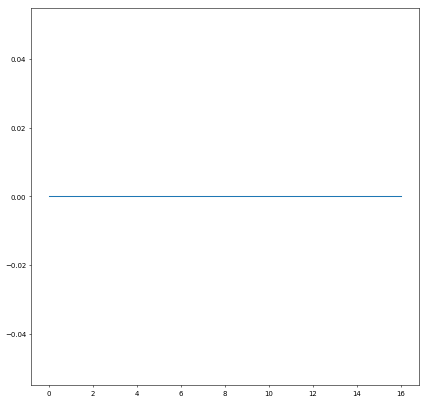

In [82]:
x = [i for i in range(len(nei))]
fig = plt.figure(figsize=(10,10),dpi=50)
plt.plot(x,nei)
plt.show()

In [83]:
[ len(Board.prey[i]._neighbours) for i in range(20)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [241]:
class TestClass:
    def __init__(self):
        test = ExtendedBoids(board_size = (500,500,500),  number_of_boids = [2,3],noise = [0.00001],
                         neighbourhood_distance = [50,70], min_distance = [5], separation_weight = [0.1,0.1],
                        alignment_weight = [0.17,0.19], cohension_weight = [0.15], flat_angle = [120], z_angle = [160],
                        maximum_speed = [6.5])
        test.clear_board()
        test.create_board()
        test.populate_board()
        c=Cones()
        c.mark_bird()
        test.board_step()
        Board.prey[0].setCoordinates(0,0,0)
        Board.prey[0].setVelocities(1,0,0)
        Board.prey[1].setCoordinates(1,-1,0)
        angle = Board.prey[0].angle(Board.prey[1])
        dist = Board.prey[0].distance(Board.prey[1])
        print((dist>Board.xlim)*2.0)
        print("debugging")
        print ( angle )
        print("asserting")
        assert len(Board.prey[0].find_neighbours()) > 0
        assert angle < mt.pi/3
        assert dist < 10

0.0
debugging
0.7853981633974484
asserting


/usr/local/lib/python3.4/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


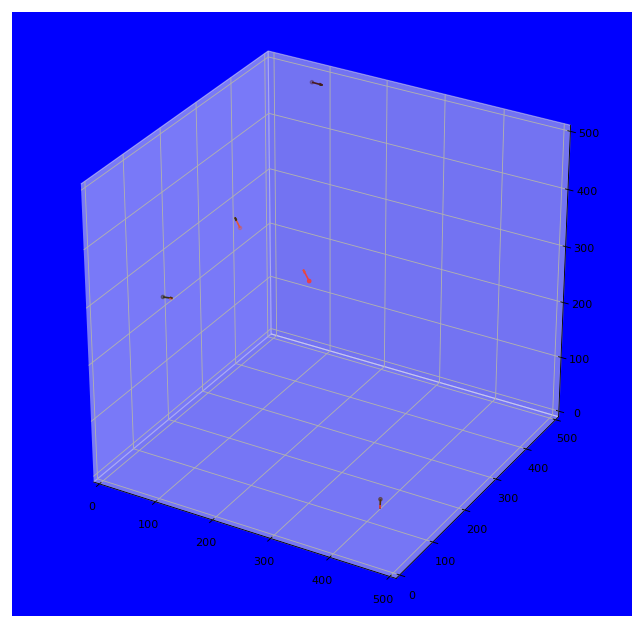

In [242]:
TestClass()

In [14]:
def save():
    os.system("ffmpeg -r 11 -i clip%01d.png -vb 2M -vcodec mpeg4 -y movie.mp4")

In [15]:
save()

In [23]:
import sys
print(sys.version)
!{sys.executable} -m pip3 install --upgrade python

3.4.3 (default, Nov 28 2017, 16:41:13) 
[GCC 4.8.4]
/usr/bin/python3: No module named pip3


In [206]:
mt.acos(3)

ValueError: math domain error

In [20]:
x = mt.nan
mt.isnan(x)

AttributeError: 'module' object has no attribute 'nan'

2.0943951023931953

[]

3.001215669352204

1.118033988749895

In [100]:
Board.prey[3].z_angle()

0.6187880142080228

In [214]:
(2<1)*1

0

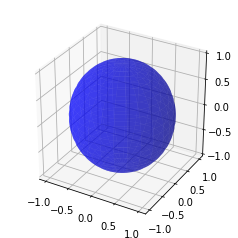

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = 1 * np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
#for i in range(2):
#    ax.plot_surface(x+random.randint(-5,5), y+random.randint(-5,5), z+random.randint(-5,5),  rstride=4, cstride=4, color='b', linewidth=0, alpha=0.5)
elev = 10.0
rot = 80.0 / 180 * np.pi
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='b', linewidth=0, alpha=0.5)
#calculate vectors for "vertical" circle


#ax.view_init(elev = elev, azim = 0)


plt.show()